# PyTorch Neural Network Classification

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Architecture of a classification neural network** | Neural networks can come in almost any shape or size, but they typically follow a similar floor plan. |
| **1. Getting binary classification data ready** | Data can be almost anything but to get started we're going to create a simple binary classification dataset. |
| **2. Building a PyTorch classification model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop** specific to classification. | 
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Improving a model (from a model perspective)** | We've trained and evaluated a model but it's not working, let's try a few things to improve it. |
| **6. Non-linearity** | So far our model has only had the ability to model straight lines, what about non-linear (non-straight) lines? |
| **7. Replicating non-linear functions** | We used **non-linear functions** to help model non-linear data, but what do these look like? |
| **8. Putting it all together with multi-class classification** | Let's put everything we've done so far for binary classification together with a multi-class classification problem. |

## 0. Architecture of a classification neural network

Before we get into writing code, let's look at the general architecture of a classification neural network.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |

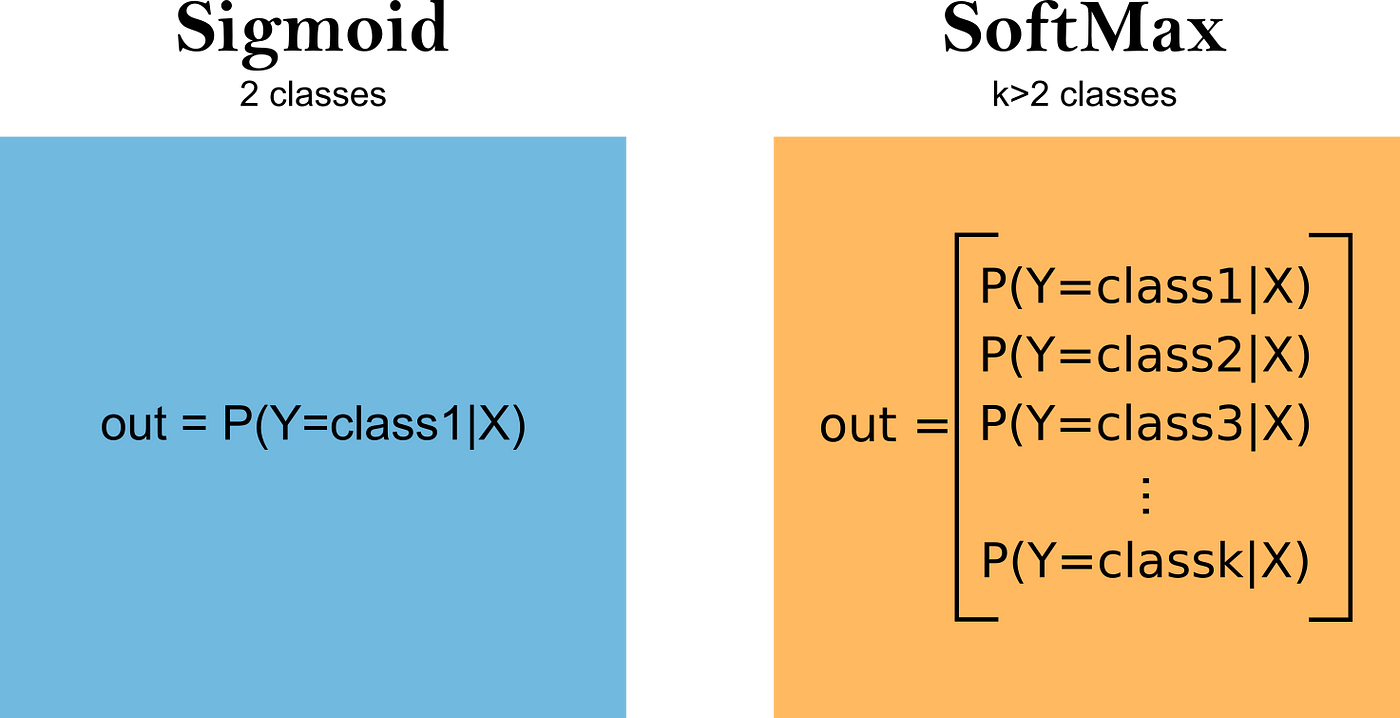

## 1. Binary data creation
Using `make_circle()` from sklearn to make 2 circles with different colored dots.

In [1]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn

In [2]:
#1000 samples
n_samples = 1000

#creating circles
X, y = make_circles(n_samples, 
                    noise=0.03,
                    random_state=42)

In [3]:
X[:5],y[:5]

#2 Values in our X, (x, y) coords, while y is labels (color)

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

#

In [4]:
circles = pd.DataFrame({'X': X[:,0],
                        'Y': X[:,1],
                        'label': y})

circles.head()

#X1 = x, X2 = y, label = color

,X,Y,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


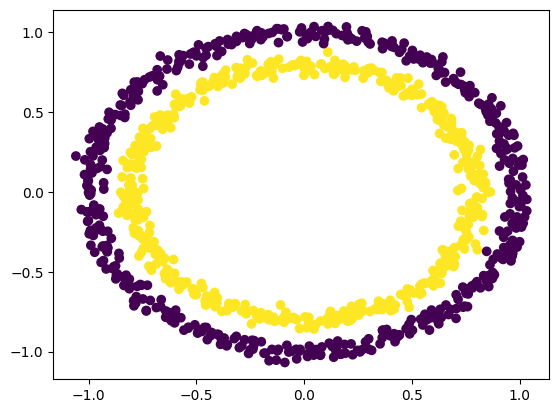

In [5]:
plt.scatter('X', 'Y', c='label', data=circles)

One of the most common errors is shape errors, where the shapes missmatch, so make yourself familiar with shapes, by checking it often.

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

Match in first dimention (1000), but not second (2, 1).

We have 2 inputs for X (vector), for 1 output for y (scalar). 

### Data to tensors

In [7]:
X = torch.from_numpy(X).type(torch.float) #double make sure its float
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
#split into train test, we can do it like before but wasier with sklear

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Model building

1. Setup device in agnostic mode, GPU if available CPU if not
2. Making model with `nn.Module`
3. Defining the loss_fn and optimizer
4. Training loop

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
f'Using: {device}'

'Using: cpu'

For model, given `X` features (2) preddict `y` label (1).

1. Subcalsses `nn.Module`
2. Creates 2 `nn.Linear` layers in the contrsuctor capable of taking in input and output
3. Define `forward()` method for forward pass
4. instatiate the model to `device`

In [10]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        #Create 2 nn.Lineat layers, instead of doing each parameter individually
        self.layer_1 = nn.Linear(in_features=2, out_features=5) #hidden layer has 5 units, (arbitary number, 10, 20), allows for more complex
        #Dont set too, high, overfitting, diminishing return, complexity, resources
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        #computation gord trough layer 1 first then layer 2
        return self.layer_2(self.layer_1(x))        
    
model = CircleModelV0().to(device)
model.state_dict

<bound method Module.state_dict of CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)>

`self.layer_1` takes 2 input features `in_features=2` and produces 5 output features `out_features=5`.

This is having **5 hidden neurons**. Why?

Allows model to learn from 5 numbers rather than 2, potentially leading to better output. This is a **hyperparameter**

![A visual example of what a classification neural network with linear activation looks like on the tensorflow playground](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-tensorflow-playground-linear-activation.png)
*A visual example of what a similar classification neural network to the one we've just built looks like. Try creating one of your own on the [TensorFlow Playground website](https://playground.tensorflow.org/).*

You can also do the same as above using [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

`nn.Sequential` performs a forward pass computation of the input data through the layers in the order they appear.

In [11]:
#replicating using Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

Looks easy, whats the catch?

As name suggests it always runs sequnetially.

In [12]:
# Untrained model predictions

untrained_preds = model(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.6770],
        [-0.6090],
        [-0.8183],
        [-0.6372],
        [-0.7592],
        [-0.7181],
        [-0.5733],
        [-0.5987],
        [-0.8205],
        [-0.6038]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Prediction dont seem to be same form or shape as the test lables, so how can we fix

### 2.1 Setup loss and Optimizer

We'll need a different loos function for this one that Linear one. We cant use `MAE`.
For binary classification we can use [`binary cross entropy`](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)

| Loss function/Optimizer | Problem type | PyTorch Code |
| ----- | ----- | ----- |
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) |
| Adam Optimizer | Classification, regression, many others. | [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) |
| Binary cross entropy loss | Binary classification | [`torch.nn.BCELossWithLogits`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) |
| Cross entropy loss | Multi-class classification | [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) |
| Mean absolute error (MAE) or L1 Loss | Regression | [`torch.nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) | 
| Mean squared error (MSE) or L2 Loss | Regression | [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) |  

*Table of various loss functions and optimizers, there are more but these are some common ones you'll see.*

PyTorch has two cross entropy implementations:
- `torch.nn.BCELoss()` - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
- `torch.nn.BCEWithLogitsLoss()` - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).


Normally the with with Sigmoid function is the better option, however when more advanced maybe seperate Sigmoid and BDELoss.

For the optimizer we can continue using `SGD`

In [13]:
#freting loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss() #BCE with sigmoid layer

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Lets also create an **evaluation metric**

If loss function mesures how *wrong* the model is the evaulation mesures how *right* it is giving a different presepective

Lets use `accuracy`

In [14]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred) #torch.eq calculate where 2 tensors are equal
    acc = (correct / len(y_pred)) * 100 #% of how many are correct over all of them
    return acc

## 3. Train model

### 3.1 From raw model ouputs to predicted labels (Logits -> prediction -> probabilities -> prediction labels)

In [15]:
#view what comes out of forward pass
y_logits = model(X_test.to(device))[:5] # first 5
y_logits

#t_logits -> unprocessed output from model

tensor([[-0.6770],
        [-0.6090],
        [-0.8183],
        [-0.6372],
        [-0.7592]], grad_fn=<SliceBackward0>)

Unprocessed so the outputs are random. What are they?

They are the ouput of the `forward()` method.

Uses the 2 layers of `nn.Linear()` which calls the following equasion:

$$y = x \cdot Weights^T + bias$$

The raw output is `logits`, its thr unprocessed output, (for binary classification we need 0 or 1, as its not like linear regression only so many answers)

So we can pass it trough a `sigmoid activation function` to normalize it into the format that we need.

![image-2.png](https://miro.medium.com/v2/resize:fit:828/format:webp/0*lzNKQdsjFVaymJTF.gif)

Visualize sigmoid activation function

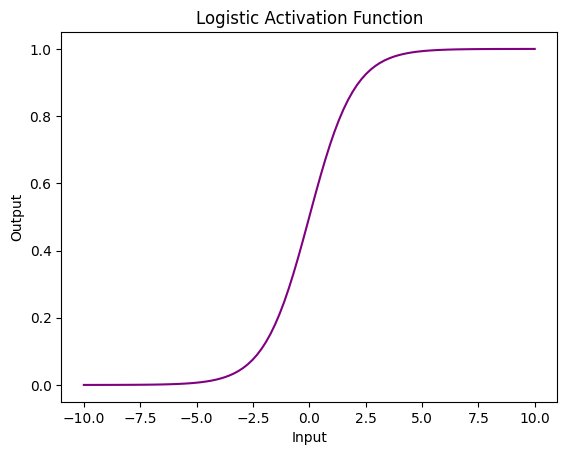

In [28]:

# importing the libraries
import torch
import matplotlib.pyplot as plt
 
# create a PyTorch tensor
x = torch.linspace(-10, 10, 100)
 
# apply the logistic activation function to the tensor
y = torch.sigmoid(x)
 
# plot the results with a custom color
plt.plot(x.numpy(), y.numpy(), color='purple')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Logistic Activation Function')
plt.show()

In [16]:
#using sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3369],
        [0.3523],
        [0.3061],
        [0.3459],
        [0.3188]], grad_fn=<SigmoidBackward0>)

We now have some sort of consitency.

They are in the form of **prediction probabilities** (y_pred_probs)

We are dealing with binary classification so we ideally want 0 1, we can out in a cut off ex:

- If `y_pred_probs` >= 0.5 (class 1)
- If `y_pred_probs` < 0.5 (class 0)

Turns prediciton probabilites into prediction labels

In [17]:
y_preds = torch.round(y_pred_probs)
y_preds.squeeze()

tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

### 3.2 Train test loop

In [18]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    #if epoch % 10 == 0:
        #print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

## 4. Make predictions and evaluate the model


Lets try to visualize what has happened so far to see where its goingw wrong

Make a plot of out model predictions, and find the boundary where its saying its 0 or 1


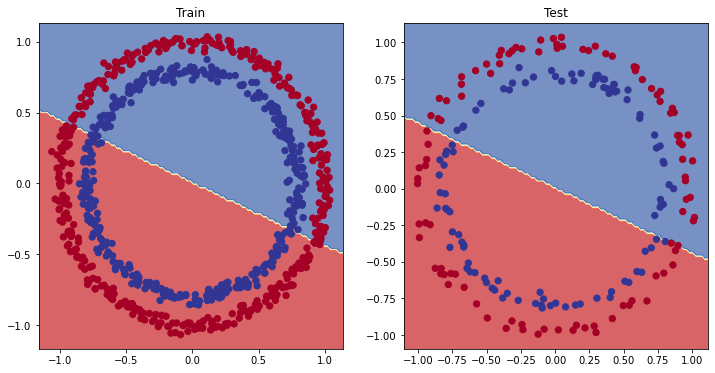
As we can see the model is drawing a straight line, underfitted

Lets add a layer, add features, and increase epoch to see if it gets better

In [19]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [20]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [22]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    #if epoch % 100 == 0:
    #    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


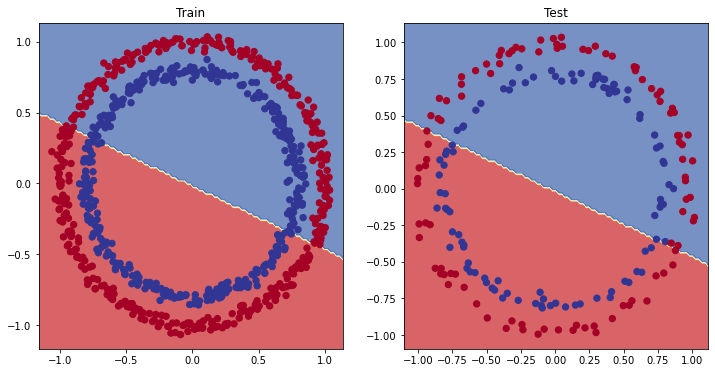

Still a striaght line, could it be a linear model maybe ?

## 6. Capacity to draw non linear model

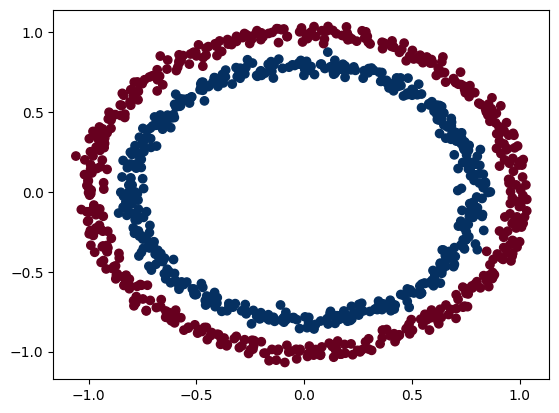

In [25]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [26]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

So far our neural network has only been using Linear functions.

Whereas the data is Non-Linear (circular)

Lets give it a non linear activation function

PyTorch has a bunch of [ready-made non-linear activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that do similar but different things. 

One of the most common and best performing is [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (rectified linear-unit, [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)).


In [32]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, x):
        return self.model(x)
    
model_3 = CircleModelV2().to(device)
print(model_3)

In [30]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### Model train with non linearity

In [36]:
# Training loop

epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_train)
    
    # 3. Zero grad
    optimizer.zero_grad()
    
    # 4. Backward pass
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print out what's happening every 10 epochs
    #if epoch % 100 == 0:
        #print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

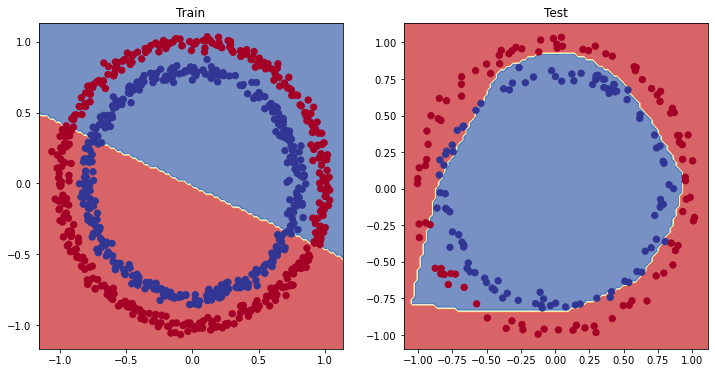

## 7. Replicating non-linear activation functions

What does a non linear activation function look like?

In [38]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

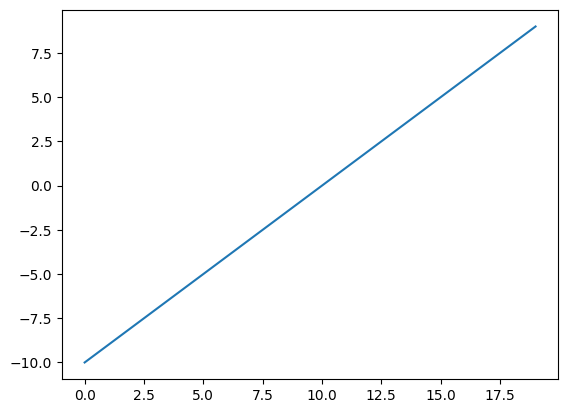

In [40]:
plt.plot(A)

Lets see how ReLu affects it

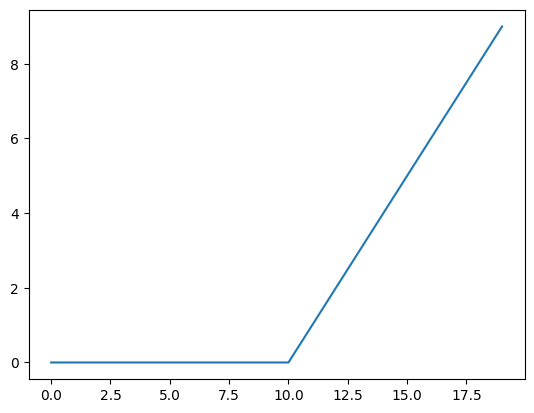

In [41]:
plt.plot(torch.relu(A))


The sigmoid function formula goes like so:

$$ out_i = \frac{1}{1+e^{-input_i}} $$ 

Or using $x$ as input:

$$ S(x) = \frac{1}{1+e^{-x_i}} $$

Where $S$ stands for sigmoid, $e$ stands for [exponential](https://en.wikipedia.org/wiki/Exponential_function) ([`torch.exp()`](https://pytorch.org/docs/stable/generated/torch.exp.html)) and $i$ stands for a particular element in a tensor.


In [43]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

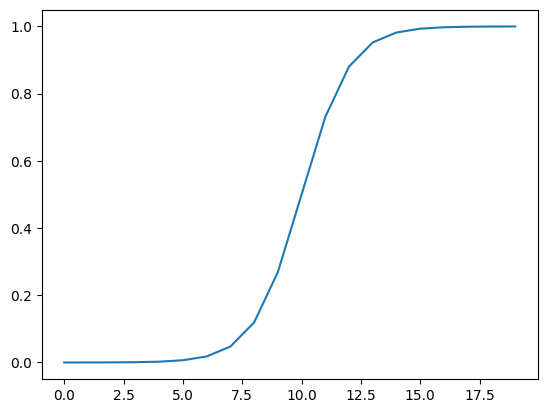

In [44]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

## 8. Multiclass PyTorch model

![binary vs multi-class classification image with the example of dog vs cat for binary classification and dog vs cat vs chicken for multi-class classification](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-binary-vs-multi-class-classification.png)

Binary vs multi-class classification image with the example of dog vs cat for binary classification and dog vs cat vs chicken for multi-class classification

### 8.1 Muticlass data creation

1. Create some multi-class data with `make_blobs()`.
2. Turn the data into tensors (the default of `make_blobs()` is to use NumPy arrays).
3. Split the data into training and test sets using `train_test_split()`.
4. Visualize the data.

In [72]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import  make_blobs
from sklearn.model_selection import train_test_split


X_blob, y_blob =  make_blobs(n_samples=1000, # 1000 samples
           n_features=2, # 2 features
           centers=4, # 2 centers
           cluster_std=1.5, # increase cluster size
           random_state=42)

X_blob[:5,:], y_blob[:5]

(array([[-8.41339595,  6.93516545],
        [-5.76648413, -6.43117072],
        [-6.04213682, -6.76610151],
        [ 3.95083749,  0.69840313],
        [ 4.25049181, -0.28154475]]),
 array([3, 2, 2, 1, 1]))

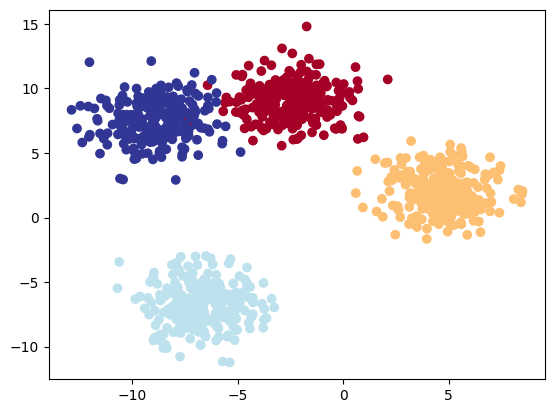

In [73]:
# Visualize the data

#feature x, feature y, target, color map
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [74]:
# To tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=0.2,
                                                    random_state=42)

### 8.2 Building a multi-class classification model in PyTorch

We'll use 3 `hyperparameters` from `nn.Module`
- `input_features` - number of `X` features coming in
- `output_features` - number of output (number of classes)
- `hidden_units` - number of hidden neurons

In [76]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

We can make out code agnostic by using arguments for in out and hidden features

In [78]:
class BlobModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        
        super().__init__()
        
        
        # Define the linear layer stack, its 3 layers total, in hidden out, in neurons -> hidden -> out
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=out_features), # how many classes are there?
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    
# Instantiate the model
# in : x,y coords, out: 4 classes, 8 hidden units
model_4 = BlobModel(in_features=2, out_features=4, hidden_units=8).to(device)

model_4.parameters

<bound method Module.parameters of BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)>

Multi class so we'll use `nn.CrossEntropyLoss()` as loss function

In [79]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

Predictions


In [82]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_train.to(device)) #what ou see is probability of it being in each class

tensor([[-0.0052,  0.3026,  0.4805,  0.1566],
        [-1.4067,  0.4005,  0.4318, -2.6872],
        [ 0.4237, -1.4113, -1.2908,  0.4085],
        ...,
        [-1.3663,  0.4683,  0.5081, -2.5794],
        [ 0.3220, -1.1643, -1.0398,  0.2901],
        [-1.3045, -0.3438, -0.3466, -2.7507]], grad_fn=<AddmmBackward0>)

In [88]:
# How many elements in a single prediction
model_4(X_train.to(device))[0].shape

torch.Size([4])

In [99]:
# Prediction with logits
y_logits = model_4(X_train.to(device))

# Perform softmax on the logits, across dim=1 (the classes dimension)
# sigmoid is for binary, softmax is for multi class
y_prob_pred = torch.softmax(y_logits, dim=1)

y_prob_pred

tensor([[0.1937, 0.2636, 0.3149, 0.2278],
        [0.0732, 0.4461, 0.4603, 0.0203],
        [0.4302, 0.0687, 0.0775, 0.4237],
        ...,
        [0.0710, 0.4449, 0.4630, 0.0211],
        [0.4080, 0.0923, 0.1045, 0.3952],
        [0.1549, 0.4049, 0.4037, 0.0365]], grad_fn=<SoftmaxBackward0>)

#since these are probabilities we want to get index of one with highest in each class

In [100]:
print(torch.argmax(y_prob_pred[0]))

tensor(2)


In [106]:
y_pred = torch.argmax(y_prob_pred, dim=1) # across classes

y_pred[:5]

tensor([2, 2, 0, 0, 2])

## 8.5 Multiclass train test loop

In [120]:
# fit the model
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Train
    model_4.train()
    
    # 1. Forward pass
    y_logits = model_4(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) #get biggest index value in each row
    
    # 2. Loss and accuracy, cross entropy needs y_train to be long (integer) as its dicrete classes
    loss = loss_fn(y_logits, y_train.to(torch.long)) # cross entropy loss with **logits**
    acc = accuracy_fn(y_pred, y_train)
    
    # 3. Zero grad
    optimizer.zero_grad()
    
    # 4. Backward pass
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    # Test
    model_4.eval()
    
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        # 2. Loss and accuracy
        test_loss = loss_fn(test_logits, y_test.to(torch.long))
        test_acc = accuracy_fn(test_pred, y_test)
        
    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        #print(f"Epoch: {epoch} | Loss: {loss.item():.5f}, Accuracy: {acc.item():.2f}% | Test loss: {test_loss.item():.5f}, Test acc: {test_acc.item():.2f}%")

SyntaxError: incomplete input (2987526540.py, line 43)

In [125]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 10.4329,  25.8438, -21.3154, -12.5394],
        [  8.7865, -29.8390,   1.0756,  16.9168],
        [-14.3230, -22.1118,  24.5257,   8.2942],
        [  4.6437,  21.5597, -13.1490, -11.3734],
        [ 17.5288,   4.6455, -21.5791,   0.1751],
        [  9.6148, -37.5856,   2.9875,  21.2202],
        [-14.7184, -13.9701,  21.9757,   3.8637],
        [ 14.8099,  -4.2730, -15.1990,   4.4159],
        [-15.0598, -35.0110,  30.1171,  15.0488],
        [ 15.5317,  -0.8853, -17.2686,   2.7447]])

Still in logits probability format, we need discrete class (index, grab with argmax)

In [ ]:
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")

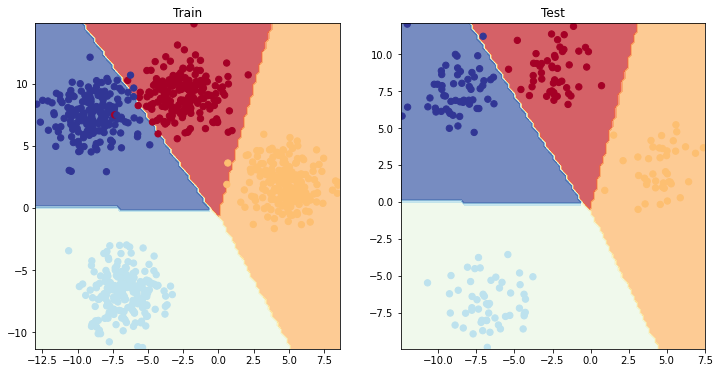

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`torchmetrics.Accuracy()`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#id3) or [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`torchmetrics.Precision()`](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html#id4) or [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`torchmetrics.Recall()`](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html#id5) or [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`torchmetrics.F1Score()`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f1score) or [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html#confusionmatrix) or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |